In [1]:
%env THEANO_FLAGS=device=gpu2,floatX=float32, lib.cnmem=0.7

import theano
import theano.tensor as T

import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import *
lref = LeakyRectify(0.2)

import numpy as np

from preprocessing import jpg_to_nparray

import os

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

env: THEANO_FLAGS=device=gpu2,floatX=float32, lib.cnmem=0.7


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: GeForce GTX 1080 (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5110)


In [2]:
#initialize our inputs

inputNoiseShape = [None, 1, 100]
inputNoise = T.tensor3("Input Noise", "float32")
inputNoiseLayer = InputLayer(inputNoiseShape, inputNoise)

inputPicShape = [None, 3, 64, 64]
inputPic = T.tensor4("Input Pic", "float32")
inputPicLayer = InputLayer(inputPicShape, inputPic)

In [3]:
#build up our generator

gen = DenseLayer(inputNoiseLayer, 256 * 8 * 8, nonlinearity=tanh)
gen = ReshapeLayer(gen, [-1, 256, 8, 8])

gen = Upscale2DLayer(gen, 2)
gen = Deconv2DLayer(gen, 256, 5, nonlinearity=lref)

gen = Upscale2DLayer(gen, 2)
gen = Deconv2DLayer(gen, 128, 5, nonlinearity=lref)

gen = Deconv2DLayer(gen, 64, 5, nonlinearity=lref)
gen = Deconv2DLayer(gen, 32, 5, nonlinearity=lref)
gen = Deconv2DLayer(gen, 16, 5, nonlinearity=lref)
gen = Deconv2DLayer(gen, 8, 5, nonlinearity=lref)
gen = Deconv2DLayer(gen, 3, 5, nonlinearity=None)

GenOutput = get_output(gen)

In [5]:
#build up our discriminator

discr = Conv2DLayer(inputPicLayer, 128, 5)
discr = Pool2DLayer(discr, 2)

discr = Conv2DLayer(discr, 256, 5)

discr = DenseLayer(discr, 256)
discr = DenseLayer(discr, 1, nonlinearity=sigmoid)

Discr_Out_Legit = get_output(discr)
Discr_Out_Fake = get_output(discr, {inputPicLayer : GenOutput})

In [6]:
#define our losses

G_loss = -(T.log(Discr_Out_Fake)).mean()
D_loss = -(T.log(Discr_Out_Legit) + T.log(1 - Discr_Out_Fake)).mean()

In [7]:
#define our tranin & generate functions

G_params = get_all_params(gen, trainable=True)
G_updates = lasagne.updates.adam(G_loss, G_params, 2e-4)
G_train = theano.function([inputNoise], G_loss, updates=G_updates, allow_input_downcast=True)

generate = theano.function([inputNoise], GenOutput, allow_input_downcast=True)

In [8]:
D_params = get_all_params(discr, trainable=True)
D_updates = lasagne.updates.adam(D_loss, D_params, 3e-4)
D_train = theano.function([inputNoise, inputPic], D_loss, updates=D_updates, allow_input_downcast=True)

discriminate = theano.function([inputPic], Discr_Out_Legit, allow_input_downcast=True)

In [9]:
pics = jpg_to_nparray("pics/", os.listdir("pics/"), (64, 64))

In [10]:
def sample_noise(M):
    ns = np.random.normal(0, 10, size=M)
    return np.float32(ns)

In [45]:
#training loop

n_epochs = 150
batch_size = 100

for epoch in range(n_epochs):
    clear_output()
    print(epoch)
    
    for i in range(0, len(pics) - batch_size, batch_size):
        nz = [sample_noise([1, 100]) for _ in range(batch_size)]
        ims = pics[i : i + batch_size]
        
        D_train(nz , ims)
        
        for _ in range(2):
            G_train(nz)

49


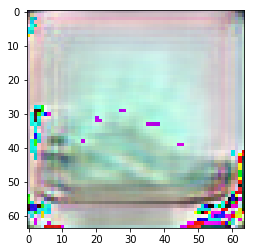

In [63]:
#let's see the results

plt.imshow(generate(sample_noise([1, 1, 100]))[0].transpose(1, 2, 0))